# **Project 2: Stock Portfolio Optimization - Assignment 3**
 Athanasakis Evangelos 2019030118  
 Fragkogiannis Yiorgos 2019030039

### Importing libraries

In [428]:
# # **Project 2: Stock Portfolio Optimization - Assignment 3**
# Athanasakis Evangelos 2019030118 // Fragkogiannis Yiorgos 2019030039


# Importing libraries


import numpy as np
import tkinter as tk #loads standard python GUI libraries
import random
from tkinter import *
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
from tqdm import tqdm
import optuna




### Environments

In [429]:
#-------------------------------__________________Environments___________________-------------------------------------------------------------------------
# Generating environments


# Create the three different environments
# We are modeling this environment using 8 states in the format: {stock_currently_holding,state_of_stock_1,state_of_stock_2}

action_keep = 0     # keep the same stock
action_switch = 1   # switch to the other stock

# This environment is used for the question 1 where we need to demonstrate that the optimal
# policy is always to stay with the stock we already have invested
fee = -0.9
# r1H = 2*r2L
# in this case r1.h=0.1 // r2.H= 0.05 // r1.L = -0.02 // r2.L = 0.01
# we have used a large transaction fee so that the best policy will always be to keep using the same stock
P1 = {

    # State {1,L,L}
    0:{
        action_keep: [
             (9/20, 0, -0.02),    # probability: 9/20, next_State: {1,L,L}, Reward: -0.02
             (1/20, 1, -0.02),    # {1,L,H}
             (9/20, 2, +0.1),     # {1,H,L}
             (1/20, 3, +0.1)      # {1,H,H}
        ],

        action_switch:[
            (9/20, 4, +0.01 + fee),    # {2,L,L}
            (1/20, 5, +0.05 + fee),    # {2,L,H}
            (9/20, 6, +0.01 + fee),    # {2,H,L}
            (1/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {1,L,H}
    1:{
        action_keep: [
             (1/20, 0, -0.02),  # {1,L,L}
             (9/20, 1, -0.02),  # {1,L,H}
             (1/20, 2, +0.1 ),  # {1,H,L}
             (9/20, 3, +0.1 )   # {1,H,H}
        ],

        action_switch:[
            (1/20, 4, +0.01 + fee),    # {2,L,L}
            (9/20, 5, +0.05 + fee),    # {2,L,H}
            (1/20, 6, +0.01 + fee),    # {2,H,L}
            (9/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {1,H,L}
    2:{
        action_keep: [
             (9/20, 0, -0.02),  # {1,L,L}
             (1/20, 1, -0.02),  # {1,L,H}
             (9/20, 2, +0.1 ),  # {1,H,L}
             (1/20, 3, +0.1 )   # {1,H,H}
        ],

        action_switch:[
            (9/20, 4, +0.01 + fee),    # {2,L,L}
            (1/20, 5, +0.05 + fee),    # {2,L,H}
            (9/20, 6, +0.01 + fee),    # {2,H,L}
            (1/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {1,H,H}
    3:{
        action_keep: [
             (1/20, 0, -0.02),  # {1,L,L}
             (9/20, 1, -0.02),  # {1,L,H}
             (1/20, 2, +0.1 ),  # {1,H,L}
             (9/20, 3, +0.1 )   # {1,H,H}
        ],

        action_switch: [
            (1/20, 4, +0.01 + fee),    # {2,L,L}
            (9/20, 5, +0.05 + fee),    # {2,L,H}
            (1/20, 6, +0.01 + fee),    # {2,H,L}
            (9/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {2,L,L}
    4:{
        action_keep: [
             (9/20, 4,  +0.01),    # {2,L,L}
             (1/20, 5,  +0.05),    # {2,L,H}
             (9/20, 6,  +0.01),    # {2,H,L}
             (1/20, 7,  +0.05)     # {2,H,H}
        ],

        action_switch:[
             (9/20, 0, -0.02 + fee),  # {1,L,L}
             (1/20, 1, -0.02 + fee),  # {1,L,H}
             (9/20, 2, +0.1  + fee),  # {1,H,L}
             (1/20, 3, +0.1  + fee)   # {1,H,H}
        ]
    },

    # State {2,L,H}
    5:{
        action_keep: [
             (1/20, 4, +0.01),    # {2,L,L}
             (9/20, 5, +0.05),    # {2,L,H}
             (1/20, 6, +0.01),    # {2,H,L}
             (9/20, 7, +0.05)     # {2,H,H}
        ],

        action_switch:[
            (1/20, 0, -0.02 + fee),  # {1,L,L}
            (9/20, 1, -0.02 + fee),  # {1,L,H}
            (1/20, 2, +0.1  + fee),  # {1,H,L}
            (9/20, 3, +0.1  + fee)   # {1,H,H}
        ]
    },

    # State {2,H,L}
    6:{
        action_keep: [
             (9/20, 4, +0.01),    # {2,L,L}
             (1/20, 5, +0.05),    # {2,L,H}
             (9/20, 6, +0.01),    # {2,H,L}
             (1/20, 7, +0.05)     # {2,H,H}
        ],

        action_switch:[
             (9/20, 0, -0.02 + fee),  # {1,L,L}
             (1/20, 1, -0.02 + fee),  # {1,L,H}
             (9/20, 2, +0.1  + fee),  # {1,H,L}
             (1/20, 3, +0.1  + fee)   # {1,H,H}
        ]
    },

    # State {2,H,H}
    7:{
        action_keep: [
             (1/20, 4, +0.01),    # {2,L,L}
             (9/20, 5, +0.05),    # {2,L,H}
             (1/20, 6, +0.01),    # {2,H,L}
             (9/20, 7, +0.05)     # {2,H,H}
        ],

        action_switch:[
             (1/20, 0, -0.02 + fee),  # {1,L,L}
             (9/20, 1, -0.02 + fee),  # {1,L,H}
             (1/20, 2, +0.1  + fee),  # {1,H,L}
             (9/20, 3, +0.1  + fee)   # {1,H,H}
        ]
    }

}


# This environment implements the stocks environment from the midterm
# It is used for the question 2 where we need to demonstrate that the optimal policy
# for some of the states is to switch and in some others to stay
fee = -0.01
P2 = {

    # State {1,L,L}
    0:{
        action_keep: [
             (9/20, 0, -0.02),    # probability: 9/20, next_State: {1,L,L}, Reward: -0.02
             (1/20, 1, -0.02),    # {1,L,H}
             (9/20, 2, +0.1),     # {1,H,L}
             (1/20, 3, +0.1)      # {1,H,H}
        ],

        action_switch:[
            (9/20, 4, +0.01 + fee),    # {2,L,L}
            (1/20, 5, +0.05 + fee),    # {2,L,H}
            (9/20, 6, +0.01 + fee),    # {2,H,L}
            (1/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {1,L,H}
    1:{
        action_keep: [
             (1/20, 0, -0.02),  # {1,L,L}
             (9/20, 1, -0.02),  # {1,L,H}
             (1/20, 2, +0.1 ),  # {1,H,L}
             (9/20, 3, +0.1 )   # {1,H,H}
        ],

        action_switch:[
            (1/20, 4, +0.01 + fee),    # {2,L,L}
            (9/20, 5, +0.05 + fee),    # {2,L,H}
            (1/20, 6, +0.01 + fee),    # {2,H,L}
            (9/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {1,H,L}
    2:{
        action_keep: [
             (9/20, 0, -0.02),  # {1,L,L}
             (1/20, 1, -0.02),  # {1,L,H}
             (9/20, 2, +0.1 ),  # {1,H,L}
             (1/20, 3, +0.1 )   # {1,H,H}
        ],

        action_switch:[
            (9/20, 4, +0.01 + fee),    # {2,L,L}
            (1/20, 5, +0.05 + fee),    # {2,L,H}
            (9/20, 6, +0.01 + fee),    # {2,H,L}
            (1/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {1,H,H}
    3:{
        action_keep: [
             (1/20, 0, -0.02),  # {1,L,L}
             (9/20, 1, -0.02),  # {1,L,H}
             (1/20, 2, +0.1 ),  # {1,H,L}
             (9/20, 3, +0.1 )   # {1,H,H}
        ],

        action_switch: [
            (1/20, 4, +0.01 + fee),    # {2,L,L}
            (9/20, 5, +0.05  + fee),    # {2,L,H}
            (1/20, 6, +0.01 + fee),    # {2,H,L}
            (9/20, 7, +0.05 + fee)     # {2,H,H}
        ]
    },

    # State {2,L,L}
    4:{
        action_keep: [
             (9/20, 4,  +0.01),    # {2,L,L}
             (1/20, 5,  +0.05),    # {2,L,H}
             (9/20, 6,  +0.01),    # {2,H,L}
             (1/20, 7,  +0.05)     # {2,H,H}
        ],

        action_switch:[
             (9/20, 0, -0.02 + fee),  # {1,L,L}
             (1/20, 1, -0.02 + fee),  # {1,L,H}
             (9/20, 2, +0.1 + fee),  # {1,H,L}
             (1/20, 3, +0.1 + fee)   # {1,H,H}
        ]
    },

    # State {2,L,H}
    5:{
        action_keep: [
             (1/20, 4, +0.01),    # {2,L,L}
             (9/20, 5, +0.05),    # {2,L,H}
             (1/20, 6, +0.01),    # {2,H,L}
             (9/20, 7, +0.05)     # {2,H,H}
        ],

        action_switch:[
            (1/20, 0, -0.02 + fee),  # {1,L,L}
            (9/20, 1, -0.02 + fee),  # {1,L,H}
            (1/20, 2, +0.1 + fee),  # {1,H,L}
            (9/20, 3, +0.1 + fee)   # {1,H,H}
        ]
    },

    # State {2,H,L}
    6:{
        action_keep: [
             (9/20, 4, +0.01),    # {2,L,L}
             (1/20, 5, +0.05),    # {2,L,H}
             (9/20, 6, +0.01),    # {2,H,L}
             (1/20, 7, +0.05)     # {2,H,H}
        ],

        action_switch:[
             (9/20, 0, -0.02 + fee),  # {1,L,L}
             (1/20, 1, -0.02 + fee),  # {1,L,H}
             (9/20, 2, +0.1 + fee),  # {1,H,L}
             (1/20, 3, +0.1 + fee)   # {1,H,H}
        ]
    },

    # State {2,H,H}
    7:{
        action_keep: [
             (1/20, 4, +0.01),    # {2,L,L}
             (9/20, 5, +0.05),    # {2,L,H}
             (1/20, 6, +0.01),    # {2,H,L}
             (9/20, 7, +0.05)     # {2,H,H}
        ],

        action_switch:[
             (1/20, 0, -0.02 + fee),  # {1,L,L}
             (9/20, 1, -0.02 + fee),  # {1,L,H}
             (1/20, 2, +0.1 + fee),  # {1,H,L}
             (9/20, 3, +0.1 + fee)   # {1,H,H}
        ]
    }

}


# This environment implements the generic scenario of question 3 where for every stock
# ri_H,ri_L are chosen uniformly in [-0.02, 0.1] and transition probabilities pi_HL, pi_LH
# are equal to 0.1 for half the stocks and 0.5 for the other half.

# Since every stock can have two price states, the number of total states in the MDP
# we are creating will be = NumOfStoscks*2^numOfStocks


def decimal_to_binary_array(decimal, length):

    # Convert decimal to binary string (strip '0b' prefix)
    binary_string = bin(decimal)[2:]

    # Determine padding length
    padding_length = max(0, length - len(binary_string))

    # Pad binary string with leading zeros if needed
    padded_binary_string = '0' * padding_length + binary_string

    # Convert padded binary string to list of binary digits
    binary_array = [int(bit) for bit in padded_binary_string]

    return binary_array


# Function that generates the environment of N stocks dynamically, with a transaction fee
def generate_environment(N,fee):

    states_for_each_stock = 2**N
    total_states = N * states_for_each_stock
    max_state_length = N

    P = {}
    pi = []
    #Creating transition probabilities for the keep action
    #of EACH stock
    for i in range(0,N):
        if(i < N/2):
            # pi_HL = pi_LH = 0.1 | # pi_HH = pi_LL = 0.9
            row = [0.9,0.1,0.1,0.9] #[LL,LH,HL,HH]
        else:
            # pi_HL = pi_LH = 0.5 | # pi_HH = pi_LL = 0.5
            row = [0.5,0.5,0.5,0.5] #[LL,LH,HL,HH]
        pi.append(row)

    progress_bar = tqdm(range(0, total_states))
    for i in progress_bar:
        SubDictionary={}
        action_Keep = []
        action_Switch = []

        # find what stock we are reffering to
        # Stock ids start from 0
        stock = i // states_for_each_stock

        ##########################
        # We define states of L and H with binary ids
        # For example for 2 stocks this translation occurs:
        # LL -> 0,0 -> 0
        # LH -> 0,1 -> 1
        # HL -> 1,0 -> 2
        # HH -> 1,1 -> 3
        # The binary ids are then translated to decimals so that
        # we can use them in code
        ##########################

        current_state = i - stock * states_for_each_stock # find where this specific stock starts at the total_states environment
                                                          # this is necessary to calculate the transition probabilities
        # Convert decimal to binary string
        # Convert the binary string to a list of integers (0s and 1s)
        curr_state_array = decimal_to_binary_array(current_state, max_state_length)
        # We can now use the array to find if each stock is in high (1s) or low (0s) state
        # So We now know that we are at state {x,L,L,H....,H} with x the number of current stock

        #__Keep Stock ________________________________________________________________________________________________________________
        for j in range (stock*2**N, ((stock+1)*2**N)): # for every possible transition when keeping the same stock
            state_to_trans = j - stock * states_for_each_stock          # value (H or L) of all of the stocks at the state we will transition to, in decimal form (0,1,2,3...)
            trans_state_array = decimal_to_binary_array(state_to_trans, max_state_length) # convert to binary and take each bit separately (0 for L and 1 for H)
    
            transitionProb = 1

            for k in range(len(trans_state_array)):
                stock_state_trans = trans_state_array[k]  # 0 or 1 // low or high
                stock_state_current = curr_state_array[k] # 0 or 1 // low or high

                if(stock_state_current == 0 and stock_state_trans == 0):       # Pi_LL
                    transitionProb = transitionProb * pi[stock][0]
                elif(stock_state_current == 0 and stock_state_trans == 1):     # pi_LH
                    transitionProb = transitionProb * pi[stock][1]
                elif(stock_state_current == 1 and stock_state_trans == 0):     # pi_HL
                    transitionProb = transitionProb * pi[stock][2]
                else:                                                          # pi_HH
                    transitionProb = transitionProb * pi[stock][3]
            nextState = j

            reward = random.uniform(-0.02, 0.1)
            action_Keep.append((transitionProb,nextState,reward))
            #print("\nSWITCH\n")

        #-----------------------------------------------------------------------------------------------------------------------------------------------
        #fee = 0
        #__Switch Stock ________________________________________________________________________________________________________________
        # progress_bar = tqdm(range (0, total_states))
        for j in range (0, total_states): # for every possible transition 
            trans_stock = j // states_for_each_stock
            
            
            if(trans_stock == stock):     # check if the transition stock is the same as the stock we start from
                continue                  # we have already handle this situation above so we move on

            trans_state = j - trans_stock * states_for_each_stock

            trans_state_array = decimal_to_binary_array(trans_state, max_state_length)

            transitionProb = 1

            for k in range(len(trans_state_array)):

                stock_state_trans = trans_state_array[k] # 0 or 1 // low or high
                stock_state_current = curr_state_array[k] # 0 or 1 // low or high

                if(stock_state_current == 0 and stock_state_trans == 0):       # Pi_LL
                    transitionProb = transitionProb * pi[stock][0]

                elif(stock_state_current == 0 and stock_state_trans == 1):     # pi_LH
                    transitionProb = transitionProb * pi[stock][1]

                elif(stock_state_current == 1 and stock_state_trans == 0):     # pi_HL
                    transitionProb = transitionProb * pi[stock][2]

                else:                                                          # pi_HH
                    transitionProb = transitionProb * pi[stock][3]


            nextState = j

            reward = random.uniform(-0.02, 0.1) - fee
            action_Switch.append((transitionProb*(1/(N-1)),nextState,reward))
            

        #-----------------------------------------------------------------------------------------------------------------------------------------------
        SubDictionary[action_keep] = action_Keep
        SubDictionary[action_switch] = action_Switch
        P[i]=SubDictionary



    return P



## Phase 1, Policy Evaluation/Iteration

In [430]:

def policy_evaluation(pi, P, gamma = 1.0, epsilon = 1e-10):  #inputs: (1) policy to be evaluated, (2) model of the environment (transition probabilities, etc., see previous cell), (3) discount factor (with default = 1), (4) convergence error (default = 10^{-10})
    #print("in policy EVALUATION")
    t = 0   #there's more elegant ways to do this
    prev_V = np.zeros(len(P)) # use as "cost-to-go", i.e. for V(s')
    while True:
        V = np.zeros(len(P)) # current value function to be learnerd
        for s in range(len(P)):  # do for every state
            for prob, next_state, reward in P[s][pi(s)]:  # calculate one Bellman step --> i.e., sum over all probabilities of transitions and reward for that state, the action suggested by the (fixed) policy, the reward earned (dictated by the model), and the cost-to-go from the next state (which is also decided by the model)
                V[s] = np.int64(V[s] + prob * (reward + gamma * prev_V[next_state]))
        if np.max(np.abs(prev_V - V)) < epsilon: #check if the new V estimate is close enough to the previous one;     
            break # if yes, finish loop
        prev_V = V.copy() #freeze the new values (to be used as the next V(s'))
        t += 1
    return V


def policy_improvement(V, P, gamma=1.0):  # takes a value function (as the cost to go V(s')), a model, and a discount parameter
    #print("in policy IMPROVEMENT")
    Q = np.zeros((len(P), len(P[0])), dtype=np.float64) #create a Q value array
    for s in range(len(P)):        # for every state in the environment/model
        for a in range(len(P[s])):  # and for every action in that state
            for prob, next_state, reward in P[s][a]:  #evaluate the action value based on the model and Value function given (which corresponds to the previous policy that we are trying to improve) 
                Q[s][a] += prob * (reward + gamma * V[next_state])
    new_pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]  # this basically creates the new (improved) policy by choosing at each state s the action a that has the highest Q value (based on the Q array we just calculated)
    # lambda is a "fancy" way of creating a function without formally defining it (e.g. simply to return, as here...or to use internally in another function)
    # you can implement this in a much simpler way, by using just a few more lines of code -- if this command is not clear, I suggest to try coding this yourself
    
    return new_pi,Q

# policy iteration is simple, it will call alternatively policy evaluation then policy improvement, till the policy converges.

def policy_iteration(P, gamma = 1.0, epsilon = 1e-10):
    t = 0
    random_actions = np.random.choice(tuple(P[0].keys()), len(P))     # start with random actions for each state  
    pi = lambda s: {s:a for s, a in enumerate(random_actions)}[s]     # and define your initial policy pi_0 based on these action (remember, we are passing policies around as python "functions", hence the need for this second line)

    while True:
        old_pi = {s: pi(s) for s in range(len(P))}  #keep the old policy to compare with new
        V = policy_evaluation(pi,P,gamma,epsilon)   #evaluate latest policy --> you receive its converged value function
        pi,Q_table = policy_improvement(V,P,gamma)          #get a better policy using the value function of the previous one just calculated 
        
        t += 1    
        if old_pi == {s:pi(s) for s in range(len(P))}: # you have converged to the optimal policy if the "improved" policy is exactly the same as in the previous step
            break
    print('Converged after %d Policy Iterations' %t) #keep track of the number of (outer) iterations to converge
    return V,pi,Q_table


# Function to print policy
def print_policy(policy, num_states=8):
    for s in range(num_states):
        print(f"State {s}: Action {policy(s)}")
     

### Useful Functions for Tubular Qlearning and DQL

In [431]:
def calculate_difference_and_mse(q1, q2):
    # Ensure the tables have the same dimensions
    if len(q1) != len(q2) or any(len(row1) != len(row2) for row1, row2 in zip(q1, q2)):
        raise ValueError("Both tables must have the same dimensions.")
    
    result = []
    total_squared_error = 0
    num_elements = 0
    
    for row1, row2 in zip(q1, q2):
        row_diff = []
        for element1, element2 in zip(row1, row2):
            diff = element1 - element2
            row_diff.append(diff)
            total_squared_error += diff ** 2
            num_elements += 1
        result.append(row_diff)
    
    mse = total_squared_error / num_elements
    return result, mse


def check_q_table_convergence(prev_Q, current_Q, epsilon=0.001):
    """
    Checks if the Q-table has converged.

    Parameters:
    - prev_Q (np.ndarray): Previous Q-table.
    - current_Q (np.ndarray): Current Q-table.
    - epsilon (float): Convergence threshold.

    Returns:
    - bool: True if Q-table has converged, False otherwise.
    """
    if prev_Q is None:
        return False  # Cannot determine convergence without a previous Q-table
    
    # Calculate the maximum absolute difference between corresponding Q-values
    max_diff = np.max(np.abs(prev_Q - current_Q))
    
    # Check if the maximum difference is less than epsilon
    if max_diff < epsilon:
        return True  # Q-table has converged
    
    return False  # Q-table has not converged yet


# This function is used to simulate the environments response
# It gets as input the environment, the current state and the action that we have selected
# and it returns the next state and the reward
def get_response(environment, state, action):
    P = environment
    response = P[state][action] # get next states, transition probabilities and transaction rewards
                                # based on the current state and the action we want to make   


    # we use random.choices to get a random next state based on the weighted probabilities of the next states
    probabilities = []
    avail_choices = range(len(P[state][action]))
    # print("Choises = ",avail_choices)
    # print("i in range ",len(P[state][action]))
    for i in range(len(P[state][action])): 
        probabilities.append(response[i][0])


    # because depending on the action (keep or switch) the num of actions we can take is different
    # hence, we check what the action we do is and declare the choices array accordingly
        
    # Make a random choice based on probabilities
    # k=1: Specifies that we want to make a single random choice.
    # [0] is used to extract the single element from that list
    random_choice = random.choices(avail_choices, weights=probabilities, k=1)[0]
    #print(random_choice)
    next_state = response [random_choice][1] # get next state
    reward = response [random_choice][2]     # get reward

    return next_state,reward



# Phase 2
 Implementing Tubular Q-Learning

In [432]:
#==============================================================================================================================
#################### Q-Learning ################
#===== Hyperparameters ===================
# alpha -> Learning rate
# gamma -> Discount factor
# epsilon ->  # Exploration rate
# epsilon_decay -> Decay rate for epsilon
# min_epsilon -> Minimum epsilon value
# num_episodes -> Number of episodes

def implement_Q_learning(env, num_of_episodes, alpha, gamma, epsilon_decay=0.999, alpha_decay=0.001, finding_parameters=False):
    # arrays to track the values of epsilon, alpha and rewards
    epsilon_tracker = np.zeros(num_of_episodes+1)
    alpha_tracker = np.zeros(num_of_episodes+1)
    mean_rewards_per_episode = np.zeros(num_of_episodes+1)
   
    Q = np.zeros((len(env),len(env[0])))
    epsilon = 1.0                # Exploration rate0
    #epsilon_decay = 0.99        # Decay rate for epsilon
    min_epsilon = 0.1            # Minimum epsilon value
    #alpha_decay = 0.01
    initial_alpha = alpha
    min_alpha = 0.001
    convergence_episode = float('inf')  # Initialize with a large number
    conv_counter = 0

    progress_bar = tqdm(range(num_of_episodes))

    for episode in progress_bar: 
        prev_Q = np.copy(Q)

        current_state = random.randint(0, len(env)-1) # select a random starting state
        cumulative_episode_reward = 0
        tmp_reward = []
        
        for _ in range(100):      # do 100 steps do get a feel for what happens in the environment
            # decide if we are going to explore or to exploit based on the epsilon value
            if random.uniform(0,1) < epsilon:
                # Explore by picking a random action
                action = random.choice([0,1])
                #print("EXLORE ACTION: ",action)
            else:
                action = np.argmax(Q[current_state])

            next_state,reward = get_response(env, current_state, action)
            
            Q[current_state,action] = Q[current_state,action] + alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[current_state,action]
            )

            current_state = next_state    
            cumulative_episode_reward += reward
            tmp_reward.append(reward)

        # update the hyperparameters   
        epsilon_tracker[episode] = epsilon
        alpha_tracker[episode] = alpha  
        mean_rewards_per_episode[episode] = np.mean(tmp_reward)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        alpha = max(min_alpha, initial_alpha * np.exp(-alpha_decay * episode))

        #print("epsilon: ",epsilon)
        if finding_parameters == True and check_q_table_convergence(prev_Q, Q, epsilon=0.00002):
            conv_counter += 1
            if conv_counter > 2:  # Adjust convergence criteria based on your problem
                # convergence_episode = min(convergence_episode, episode)
                convergence_episode = episode
                # print("prev_Q:", prev_Q)
                # print("Q:", Q)
                print("convergence_episode = ",convergence_episode)
                # print(np.argmax(Q,axis=1))
                conv_counter = 0
                break


    # convergence_episode = None
    return Q, convergence_episode, mean_rewards_per_episode, epsilon_tracker, alpha_tracker



# environment = P2
# alpha = 0.5
# gamma = 0
# V_opt1,P_opt1,Q_opt = policy_iteration(environment,gamma)


# Define objective function for Optuna
# Optuna tries to minimise the output of the objective function by modifying the hyperparameters of the tubular q learning algorithm
# The output of the function will be the mse of the policy found at convergence summed up with the number of steps it took to converge
# Because finding a correct policy is more important then the number of steps, mse is (weighted) multiplied with 10^14 (so that it has greater impact on 
# the output of the objective function)
def objective(trial):    
    #environment = P2  # Define your environment here
    num_of_episodes = 10000  # Adjust as needed
    alpha = trial.suggest_float('alpha', 0.5, 0.9, log=True)
    gamma = 0
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.95, 0.999)
    alpha_decay = trial.suggest_float('alpha_decay', 0.001, 0.01)
    finding_parameters = True    
    Q, convergence_episode,_,_,_ = implement_Q_learning(environment, num_of_episodes, alpha, gamma, epsilon_decay, alpha_decay, finding_parameters)
    print(np.argmax(Q,axis=1))
    
    # Return the inverse of convergence episode (maximize speed)
    convergence_episode = convergence_episode if convergence_episode != float('inf') else 10000
    r, mse = calculate_difference_and_mse(Q_opt, Q)   
    difference_count = sum(1 for x, y in zip(np.argmax(Q_opt,axis=1), np.argmax(Q,axis=1)) if x != y)
    result = mse * 10000000000000000 * (difference_count+1) + convergence_episode/10 
    print("mse: ",mse," result: ", result)
    return result


def count_tables_differences(table1, table2):
    if len(table1) != len(table2):
        raise ValueError("Both tables must have the same length.")
    
    difference_count = sum(1 for x, y in zip(table1, table2) if x != y)
    return difference_count
    


# Implementing a Deep Q-Learning Neural Network 

In [433]:

####################____TASK3____########################################

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # output layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x



# Class That Implements Our Deep Q-Network
class stock_market_trading_DQN():    
    # HyperParameters
    alpha = 0.001              # Learning rate
    gamma = 0              # Discount Factor
    synching_period = 100    # After this many batches we synch the target nn with the policy nn
    replay_buffer_size = 10000 # Size of replay buffer
    min_batch_size = 64      # Size of each batch
    #optimizer = optim.Adam(q_network.parameters(), lr=0.001)

    # Define Huber as our loss function
    # loss_func = nn.SmoothL1Loss()
    loss_func = nn.MSELoss()
    optimizer = None
    ACTIONS = [0,1]
    num_actions = 2
    
    # Encode the input state 
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor
            
    # This method is responsible to train our network based on a number of 'episodes'
    def train_DQN(self, episodes,environment,gamma,lr):
        P = environment
        num_of_states = len(P)
        num_of_actions = len(P[0])
        
        mean_rewards_per_episode = np.zeros(episodes+1)

        epsilon = 1 # Exploration rate
        self.gamma = gamma
        self.alpha = lr
        memory_buffer = ReplayMemory(self.replay_buffer_size)
        #memory_buffer = [[] for _ in range(self.replay_buffer_size)] 
        
        #memory_buffer[i % 1000] = [0,1,2,3]
        
        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        # We create a NN with num of input nodes equal to the num of the total states 
        # The num of output layer nodes is equal to the num of the total actions
        # The hidden layer's num of nodes is equal to the num of states -> this is adjustable
        policy_dqn = DQN(in_states=num_of_states, h1_nodes=num_of_states, out_actions=num_of_actions)
        target_dqn = DQN(in_states=num_of_states, h1_nodes=num_of_states, out_actions=num_of_actions)

        # initialize the 2 networks to be the same 
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # print('Policy (random, before training):')
        # self.print_dqn(policy_dqn)
        # print('===============================================================')
        # print('===============================================================')

        # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        # self.optimizer = torch.optim.RMSprop(policy_dqn.parameters(), lr=self.alpha, alpha=0.99, 
        #                                      eps=1e-08, weight_decay=0, momentum=0, centered=False)
        
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.alpha)
        # optimizer = SGD([parameter], lr=0.1)
        
        # keep track of the reward at each round 
        reward_tracking = np.zeros(episodes)
        # List to keep track of epsilon decay
        epsilon_tracking = []
        synch_counter = 0 # which step we are on 
        
        progress_bar = tqdm(range(episodes))
        for i in progress_bar:
            current_state = random.randint(0, len(P)-1) # select a random starting state
            tmp_reward = []

            for _ in range(100):      # do 100 steps do get a feel for what happens in the environment
                # decide if we are going to explore or to exploit based on the epsilon value
                # if random.uniform(0,1) < epsilon:
                if random.random() < epsilon:
                    #action = np.random.binomial(1,0.5)     # Explore by picking a random action
                    action = random.choice([0,1])
                else:
                     # From the output layer, choose the node output (action) with the maximum value
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(current_state, num_of_states)).argmax().item()
                    
                # get the response from the environment
                next_state,reward = get_response(P, current_state, action)
                # reward_tracking[i] = reward
                
                # Store the environments response into our memory        
                # memory_buffer[step % 1000] = [current_state, action, next_state, reward]
                memory_buffer.append((current_state, action, next_state, reward)) 
            
                # update the next state
                current_state = next_state    
            
                # Increment step counter
                synch_counter += 1
                tmp_reward.append(reward)
            # Perform the optimization
            if(len(memory_buffer) > self.min_batch_size):

                #mini_batch = self.sample_mem_buffer(memory_buffer, self.min_batch_size)
                mini_batch = memory_buffer.sample(self.min_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                #epsilon = max(epsilon * 0.99, 0.1)

                # Copy policy network to target network after a certain number of steps
                ### CHECK
                # if (step % self.synching_period) == 0:
                if synch_counter > self.synching_period :
                # if (synch_counter  self.synching_period): 
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    synch_counter = 0
                #tmp_reward += reward
            mean_rewards_per_episode[i] = np.mean(tmp_reward)
        # return the optimal policy
        #return policy_dqn.state_dict()
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")
        return policy_dqn,mean_rewards_per_episode
                
    def optimize(self,mini_batch, policy_dqn, target_dqn):
        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward in mini_batch:
            # Calculate target q value 
            # We disable the gradient tracking for memory optimization
            with torch.no_grad():
                # Here we get the optimal output we SHOULD have gotten according to the target NN
                target = torch.FloatTensor(
                    # For DQNs the target NNs parameters are modified according to the equation
                    # Q[state,action] = reward + γ *max{Q[next_state]}
                    reward + self.gamma * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                )
                    
            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states)) 

            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # calculate the loss for all the batch  
        loss = self.loss_func(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model by running back-propagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
    # Test function
    def test_DQN(self, episodes,environment):
        # Create FrozenLake instance
        P = environment
        num_of_states = len(P)
        num_of_actions = len(P[0])

        # Load learned policy
        policy_dqn = DQN(in_states=num_of_states, h1_nodes=num_of_states, out_actions=num_of_actions) 
 
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        # print('Policy (trained):')
        # self.print_dqn(policy_dqn)

        for i in range(episodes):
            current_state = random.randint(0, num_of_states-1)

            for _ in range(100):
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(current_state, num_of_states)).argmax().item()
                # Execute action
                current_state,reward = get_response(P, current_state, action)

        
        
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features
        Q_table = np.zeros((num_states, self.num_actions))

        # Loop each state and print policy to console
        for s in range(num_states):

            q_values_element = dqn(self.state_to_dqn_input(s, num_states)).tolist()
            Q_table[s] = q_values_element
            
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end
            #

            # Map the best action
            best_action = dqn(self.state_to_dqn_input(s, num_states)).argmax()

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end='\n')         
            if (s+1)%4==0:
                print() # Print a newline every 4 states
            
        #Q_table_transposed = [list(row) for row in zip(*Q_table)]
        return Q_table

### Optuna study for DQN (hyperparameter auto-tuning)

In [434]:
# def objective(trial):
#     # Hyperparameters to tune
#     alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
#     # gamma = trial.suggest_uniform('gamma', 0.8, 1.0)
#     gamma = 0
#     synching_period = trial.suggest_int('synching_period', 50, 500)
#     replay_buffer_size = trial.suggest_int('replay_buffer_size', 1000, 20000)
#     min_batch_size = trial.suggest_int('min_batch_size', 32, 256)
    
#     # Create an instance of the stock_market_trading_DQN class
#     dqn_agent = stock_market_trading_DQN()
    
#     # Dummy environment
#     num_states = 16
#     num_actions = 2
#     P = np.random.rand(num_states, num_actions)
    
#     # Train the DQN with the given hyperparameters
#     trained_policy = dqn_agent.train_DQN(
#         episodes=500,
#         environment=P,
#         gamma=gamma,
#         lr=alpha
#     )
    
#     # Test the trained DQN
#     total_reward = 0
#     for _ in range(10):  # Run multiple episodes for evaluation
#         current_state = random.randint(0, len(P) - 1)
#         for _ in range(100):  # Steps in an episode
#             with torch.no_grad():
#                 action = trained_policy(dqn_agent.state_to_dqn_input(current_state, num_states)).argmax().item()
#             current_state, reward = get_response(P, current_state, action)
#             total_reward += reward
    
#     # Return the total reward as the objective to maximize
#     return total_reward

# # Create a study and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Best hyperparameters: ', study.best_params)

# Choose Environment

In [435]:
#environment = P1
environment = P2
environment = generate_environment(6,0.01)
#print(environment)
gamma = 0

100%|██████████| 384/384 [00:00<00:00, 542.50it/s] 


Find Optimal Policy (policy Iteration -> Ground Truth)

In [436]:
V_opt1,P_opt1,Q_opt = policy_iteration(environment,gamma)
print("Optial Policy From Policy Iteration (Phase 1)")
print(np.argmax(Q_opt,axis=1))

Converged after 2 Policy Iterations
Optial Policy From Policy Iteration (Phase 1)
[0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Run Tubular Q-Learning

[I 2024-07-19 12:21:17,943] A new study created in memory with name: no-name-aed3daa4-d4a4-430d-ab44-e9655ebe4d9c
100%|██████████| 10000/10000 [00:13<00:00, 766.70it/s]
[I 2024-07-19 12:21:30,991] Trial 0 finished with value: 21525365865862.66 and parameters: {'alpha': 0.8491480952162173, 'epsilon_decay': 0.9549591186727926, 'alpha_decay': 0.0032907786217611468}. Best is trial 0 with value: 21525365865862.66.


[0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0
 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
mse:  5.9792682957951836e-05  result:  21525365865862.66


100%|██████████| 10000/10000 [00:18<00:00, 529.72it/s]
[I 2024-07-19 12:21:49,873] Trial 1 finished with value: 117803632232204.16 and parameters: {'alpha': 0.6837496796823592, 'epsilon_decay': 0.9510459635789111, 'alpha_decay': 0.009990769823757982}. Best is trial 0 with value: 21525365865862.66.


[0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0
 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1
 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
mse:  0.0001613748386728824  result:  117803632232204.16


100%|██████████| 10000/10000 [00:18<00:00, 555.18it/s]
[I 2024-07-19 12:22:07,888] Trial 2 finished with value: 46880849064679.266 and parameters: {'alpha': 0.5796036659876925, 'epsilon_decay': 0.9679858750535418, 'alpha_decay': 0.0055319756602190805}. Best is trial 0 with value: 21525365865862.66.


[0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0
 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0
 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0
 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1
 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
mse:  8.845443219562126e-05  result:  46880849064679.266


100%|██████████| 10000/10000 [00:17<00:00, 574.37it/s]
[I 2024-07-19 12:22:25,303] Trial 3 finished with value: 8373735546067.86 and parameters: {'alpha': 0.5001597012746284, 'epsilon_decay': 0.9962564903363987, 'alpha_decay': 0.0018397388485616173}. Best is trial 3 with value: 8373735546067.86.


[1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0
 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mse:  2.8874950155406416e-05  result:  8373735546067.86


100%|██████████| 10000/10000 [00:16<00:00, 590.73it/s]
[I 2024-07-19 12:22:42,235] Trial 4 finished with value: 4203272591186.6885 and parameters: {'alpha': 0.7717161320807497, 'epsilon_decay': 0.9854738270297675, 'alpha_decay': 0.0012959530099072118}. Best is trial 4 with value: 4203272591186.6885.


[1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mse:  2.101636295093344e-05  result:  4203272591186.6885
Best hyperparameters:  {'alpha': 0.7717161320807497, 'epsilon_decay': 0.9854738270297675, 'alpha_decay': 0.0012959530099072118}


100%|██████████| 15000/15000 [00:26<00:00, 563.91it/s]



 0 FINAL OPTIMAL POLICY [0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 15000/15000 [00:24<00:00, 617.22it/s]



 1 FINAL OPTIMAL POLICY [0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0
 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1
 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 20000/20000 [00:29<00:00, 676.53it/s]


[0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Tabular Q-Learnig Policy [0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0
 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1

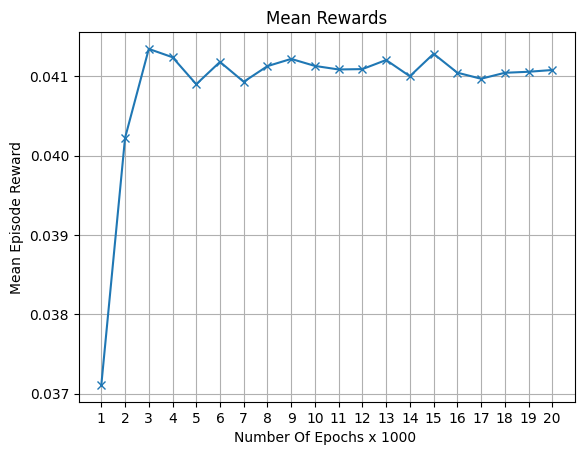

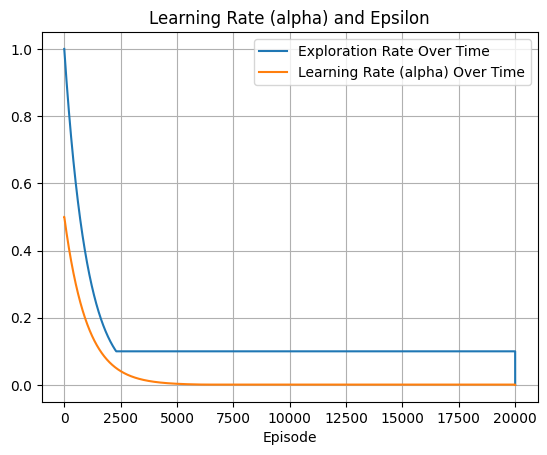

In [437]:

# Create Optuna study

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

optimal_alpha = study.best_params['alpha']
optimal_epsilon_decay = study.best_params['epsilon_decay']
optimal_alpha_decay = study.best_params['alpha_decay']


for i in range(2):
    environment = environment
    num_of_episodes = 15000
    alpha = optimal_alpha
    #gamma = 0
    epsilon_decay = optimal_epsilon_decay
    alpha_decay = optimal_alpha_decay
    finding_parameters =  False
    Q_tubular,_,_,_,_, = implement_Q_learning(environment, num_of_episodes, alpha, gamma, epsilon_decay, alpha_decay, finding_parameters)
    print(f"\n {i} FINAL OPTIMAL POLICY {np.argmax(Q_tubular,axis=1)}")

num_of_episodes = 20000
Q_tubular,_, mean_rewards, epsilon_tracker, alpha_tracker = implement_Q_learning(environment, num_of_episodes=num_of_episodes, alpha=0.5, gamma=gamma)
print(np.argmax(Q_opt,axis=1))
print(f"\nTabular Q-Learnig Policy {np.argmax(Q_tubular,axis=1)}")
print("\nQopt = \n",Q_opt)
print("Qtabular = \n",Q_tubular)


plot_mean_rewards = []
samples = 20
for i in range(samples):
    cut = int(num_of_episodes / samples)
    start = cut * i
    end = cut * (i + 1)
    mean_reward = np.mean(mean_rewards[start:end])
    plot_mean_rewards.append(mean_reward)

plt.figure()
plt.plot(range(1, samples+1), plot_mean_rewards, marker='x')
plt.xlabel(f'Number Of Epochs x {cut} ')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Rewards')
plt.xticks(range(1, samples+1))
plt.grid(True)
plt.show()

plt.figure()
plt.title('Learning Rate (alpha) and Epsilon')
plt.xlabel("Episode")
plt.grid(True)
plt.plot(np.arange(0, num_of_episodes+1), epsilon_tracker, label='Exploration Rate Over Time')
plt.plot(np.arange(0, num_of_episodes+1), alpha_tracker, label='Learning Rate (alpha) Over Time')
plt.legend()
plt.show()


# diff = count_tables_differences(Q_opt,Q_tubular)
# print("DIfference: ",diff)

 Run the DQN for the environment 

In [441]:
num_of_episodes = 6000
NN_learning_rate = 0.01
dql = stock_market_trading_DQN()
optimal_network,mean_reward = dql.train_DQN(num_of_episodes,environment,gamma,NN_learning_rate)
dql.test_DQN(10,environment)  


plot_mean_rewards = []
samples = 20
for i in range(samples):
    cut = int(num_of_episodes / samples)
    start = cut * i
    end = cut * (i + 1)
    mean_rewards = np.mean(mean_reward[start:end])
    plot_mean_rewards.append(mean_rewards)

plt.figure()
plt.plot(range(1, samples+1), plot_mean_rewards, marker='x')
plt.xlabel(f'Number Of Epochs x {cut} ')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Rewards')
plt.xticks(range(1, samples+1))
plt.grid(True)
plt.show()



 63%|██████▎   | 3805/6000 [06:22<03:40,  9.94it/s]


KeyboardInterrupt: 

# Comparing Optimal Policies Generated from diffrent algorithms

In [439]:
# Phase 1 Optimal Policy
print("Phase 1 Optimal Policy")
print_policy(P_opt1,len(environment))
print("\nOptimal Q = ",Q_opt)
print("================================================================")
# Phase 2 - Tabular Q-Learning Optimal Policy
print("Phase 2 - Tubular Q-Learning Optimal Policy")
print(np.argmax(Q_tubular,axis=1))
print("================================================================")

# Phase 2 - DQN Optimal Policy
print("Phase 2 - DQN Optimal Policy")
Q_NN = dql.print_dqn(optimal_network)
print("================================================================")

# Output difference
print("\nDifference With NN")
print(Q_NN)
difference,total_error = calculate_difference_and_mse(Q_opt,Q_NN)
print(f"difference {difference}\nTotal Error: {total_error}")


Phase 1 Optimal Policy
State 0: Action 0
State 1: Action 0
State 2: Action 0
State 3: Action 0
State 4: Action 1
State 5: Action 1
State 6: Action 0
State 7: Action 0
State 8: Action 1
State 9: Action 1
State 10: Action 0
State 11: Action 0
State 12: Action 0
State 13: Action 0
State 14: Action 0
State 15: Action 1
State 16: Action 0
State 17: Action 0
State 18: Action 0
State 19: Action 0
State 20: Action 0
State 21: Action 0
State 22: Action 0
State 23: Action 0
State 24: Action 0
State 25: Action 1
State 26: Action 0
State 27: Action 1
State 28: Action 0
State 29: Action 0
State 30: Action 1
State 31: Action 0
State 32: Action 0
State 33: Action 0
State 34: Action 1
State 35: Action 0
State 36: Action 0
State 37: Action 0
State 38: Action 0
State 39: Action 0
State 40: Action 1
State 41: Action 1
State 42: Action 1
State 43: Action 0
State 44: Action 0
State 45: Action 1
State 46: Action 0
State 47: Action 0
State 48: Action 0
State 49: Action 0
State 50: Action 0
State 51: Action 1